* `Import libraries`

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , OneHotEncoder , OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score , confusion_matrix , classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


* `Read dataset`

In [5]:
# Load the data
DATA_PATH = os.path.join(os.getcwd(), '..' , 'datasets' , 'Churn_Modelling.csv')
df = pd.read_csv(DATA_PATH)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [30]:
# Remove unnecessary columns
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

KeyError: "['RowNumber', 'CustomerId', 'Surname'] not found in axis"

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [8]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


* `EDA`

In [9]:
# check for NaN values
df.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [10]:
# Check the areas we are dealing with
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [11]:
#unbalanced dataset
df['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [12]:
df['Tenure'].unique()

array([ 2,  1,  8,  7,  4,  6,  3, 10,  5,  9,  0])

* `Data visualization & handling outliers `

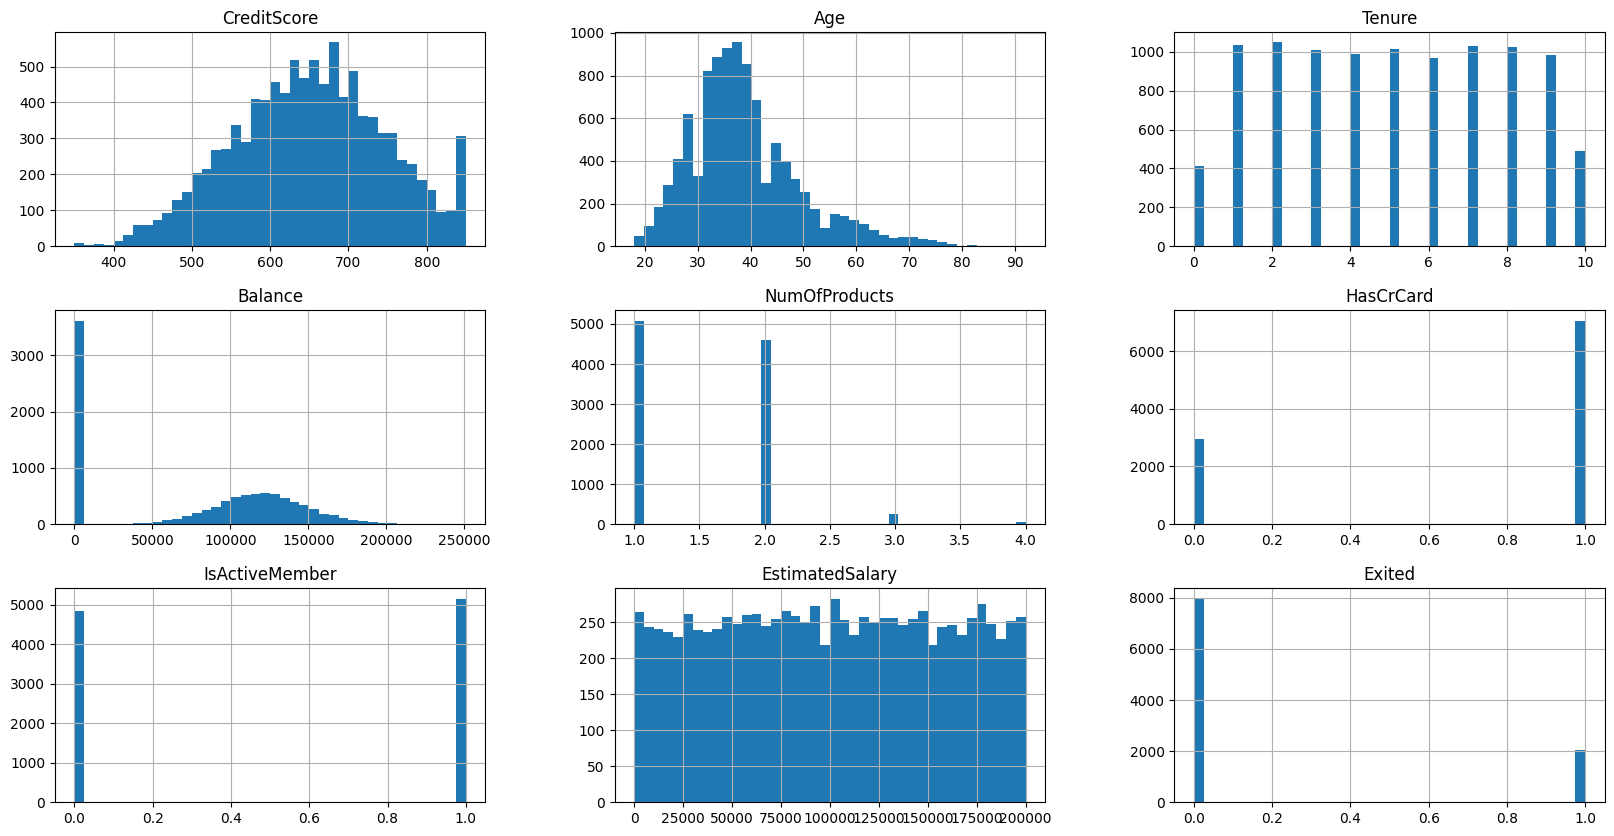

In [ ]:
# Visualize the distribution of numerical features
df.hist(bins=40, figsize=(20,10))
plt.show()

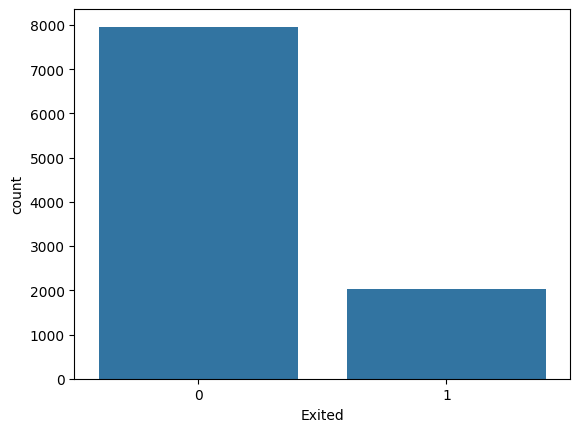

In [ ]:
# unbalanced dataset
sns.countplot(x='Exited', data=df)
plt.show()

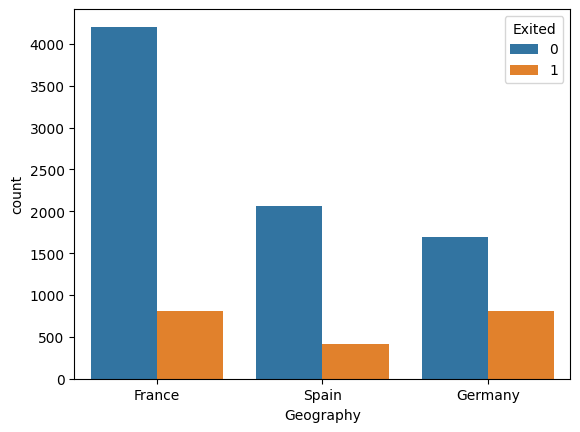

In [ ]:
sns.countplot(data=df, x='Geography', hue='Exited')
plt.show()

# it seems that germany has the highest churn rate

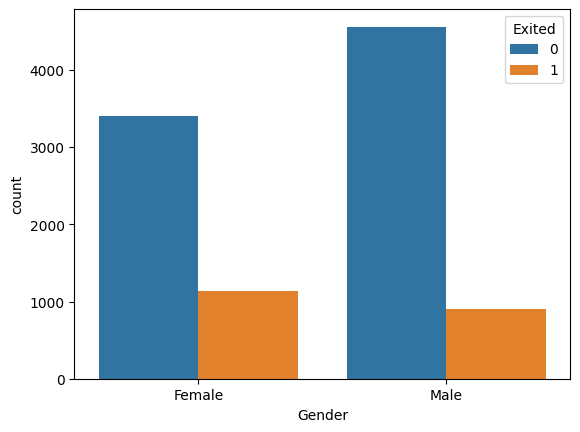

In [ ]:
sns.countplot(data=df, x='Gender', hue='Exited')
plt.show()

# Females have a slightly higher churn rate

In [ ]:
# Females have a slightly higher EstimatedSalary
df[['Gender','EstimatedSalary']].groupby('Gender')['EstimatedSalary'].mean()

Gender
Female    100601.541382
Male       99664.576931
Name: EstimatedSalary, dtype: float64

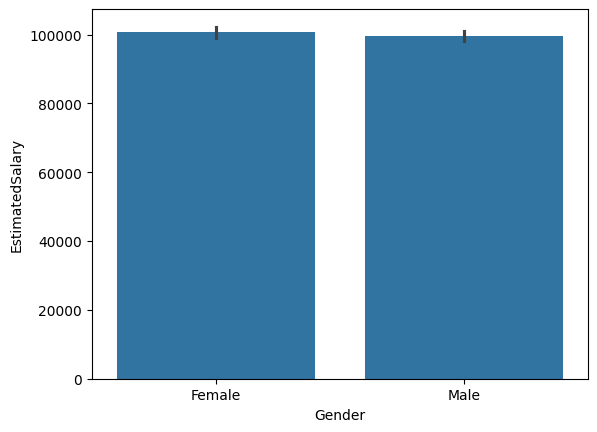

In [27]:
sns.barplot(data=df, x='Gender' , y='EstimatedSalary',estimator='mean')
plt.show()

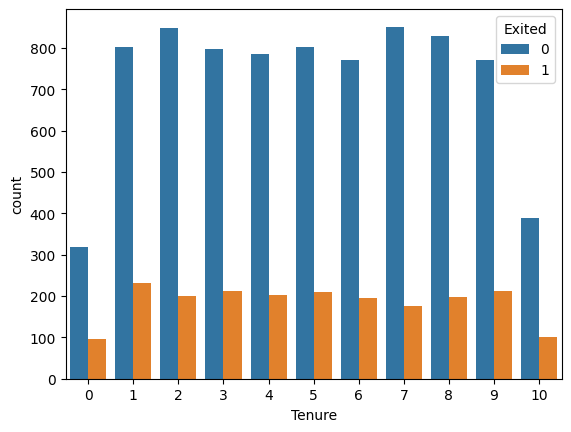

In [ ]:
# There is no clear relationship between Tenure and Churn
sns.countplot(data=df, x='Tenure', hue='Exited')
plt.show()

* `Split to test & train`


In [38]:
# feature and target split
X = df.drop(columns=['Exited'], axis=1)
y = df['Exited']

# Split to test & train
x_train  ,x_test, y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=45,shuffle =True, stratify=y)
print(f"Train shape: {x_train.shape} , {y_train.shape}")
print(f"Test shape: {x_test.shape} , {y_test.shape}")


Train shape: (8000, 10) , (8000,)
Test shape: (2000, 10) , (2000,)


* `preprocessing`

In [43]:
# slice data (numerical, categorical, ready)
num_data = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
categ_data = ['Geography','Gender']
ready_data = list(set(x_train.columns.tolist()) -set(num_data + categ_data))


In [ ]:
# testing feature importance (numerical features) -> ANOVA
_, pval = f_classif(X=x_train[num_data], y=y_train)
pval

# p-values for numerical features are all below 0.05, so we will keep them all

array([9.93415956e-002, 4.53937410e-151, 4.93061528e-027, 3.77885631e-001])

In [ ]:
# testing feature importance (categorical features) -> Chi-squared
_, pval= chi2(X=OrdinalEncoder().fit_transform(x_train[categ_data]), y=y_train)
pval

# p-values for categorical features are all below 0.05, so we will keep them all

array([1.19256538e-03, 2.10648846e-11])

In [ ]:
# testing feature importance (ready features) -> chi-squared
_, pval= chi2(X=x_train[ready_data], y=y_train)
pval

# p-values for ready features are all below 0.05, so we will keep them all

array([9.69193084e-01, 6.52077590e-02, 2.05442478e-21, 1.37949728e-01])

In [78]:
# pipeline
# Numerical : impute using median and standardscaler
# Categorical : impute using most_frequent (mode) and onehotencoder
# ready : impute using most_frequent (mode)

# Numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categ_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('OHE', OneHotEncoder(sparse_output=False, drop='first'))
])

# Ready data pipeline
ready_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Full pipeline
full_pipeline = ColumnTransformer(transformers=[
    ('numerical', num_pipeline, num_data),
    ('categorical', categ_pipeline, categ_data),
    ('ready', ready_pipeline, ready_data)
])


# Transform the data
x_train_final = full_pipeline.fit_transform(x_train)
x_test_final = full_pipeline.transform(x_test)

In [ ]:
print(f"Train shape after preprocessing: {x_train_final.shape}")
print(f"Test shape after preprocessing: {x_test_final.shape}")


Train shape after preprocessing: (8000, 11)
Test shape after preprocessing: (2000, 11)


* `Deal with imbalanced data`

In [86]:
# 1. prepare class_weights for solving imbalance dataset
vals_count = 1 - (np.bincount(y_train) / len(y_train))
vals_count = vals_count / sum(vals_count)

dict_weights = {}
for i in range(2):  # 2 classes (0, 1)
    dict_weights[i] = vals_count[i]

# to model
dict_weights

{0: np.float64(0.20375), 1: np.float64(0.79625)}

In [80]:
# 2. oversampling using SMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE(k_neighbors=5 ,random_state=45 ,sampling_strategy=0.7)
x_train_resampled ,y_train_resampled = oversample.fit_resample(x_train_final, y_train)

In [81]:
# create folder for models
MODEL_FOLDER_PATH = os.path.join(os.getcwd(), '..' , 'models')
os.makedirs(MODEL_FOLDER_PATH, exist_ok=True)

In [82]:
# dump the pipeline
joblib.dump(full_pipeline, os.path.join(MODEL_FOLDER_PATH, 'preprocessing_pipeline.pkl'))

['d:\\AI\\projects\\ML\\churn\\notebooks\\..\\models\\preprocessing_pipeline.pkl']

* `Building Models`
> Let's consider the evaluation metric to be f1_score

1. Using Logistic Regression

In [92]:
# model : 1.logistic regression (without considering the imbalance)
log = LogisticRegression(C=1.5)
log.fit(x_train_final, y_train)

# predict and evaluate
y_pred_train_log = log.predict(x_train_final)
y_pred_test_log = log.predict(x_test_final)

# using f1_score as evaluation metric
score_train_log = f1_score(y_train, y_pred_train_log)
score_test_log = f1_score(y_test, y_pred_test_log)

print(f"The f1_score using Logistic model for Training Dataset with SMOTE is {score_train_log*100:.3f}")
print(f"The f1_score using Logistic model for Testing Dataset with SMOTE is {score_test_log*100:.3f}")


The f1_score using Logistic model for Training Dataset with SMOTE is 32.437
The f1_score using Logistic model for Testing Dataset with SMOTE is 30.631


In [93]:
# model : 2.logistic regression (with class weights to solve imbalance)
log_w = LogisticRegression(C=1.5, class_weight=dict_weights)
log_w.fit(x_train_final, y_train)

# predict and evaluate
y_pred_train_log = log_w.predict(x_train_final)
y_pred_test_log = log_w.predict(x_test_final)

# using f1_score as evaluation metric
score_train_log = f1_score(y_train, y_pred_train_log)
score_test_log = f1_score(y_test, y_pred_test_log)

print(f"The f1_score using Logistic model for Training Dataset with SMOTE is {score_train_log*100:.3f}")
print(f"The f1_score using Logistic model for Testing Dataset with SMOTE is {score_test_log*100:.3f}")


The f1_score using Logistic model for Training Dataset with SMOTE is 50.011
The f1_score using Logistic model for Testing Dataset with SMOTE is 48.339


In [94]:
# model : 3.logistic regression (with oversampling (SMOTE) to solve imbalance)
log_s = LogisticRegression(C=1.5)
log_s.fit(x_train_resampled, y_train_resampled)

# predict and evaluate
y_pred_train_log = log_s.predict(x_train_final)
y_pred_test_log = log_s.predict(x_test_final)

# using f1_score as evaluation metric
score_train_log = f1_score(y_train, y_pred_train_log)
score_test_log = f1_score(y_test, y_pred_test_log)

print(f"The f1_score using Logistic model for Training Dataset with SMOTE is {score_train_log*100:.3f}")
print(f"The f1_score using Logistic model for Testing Dataset with SMOTE is {score_test_log*100:.3f}")

The f1_score using Logistic model for Training Dataset with SMOTE is 49.537
The f1_score using Logistic model for Testing Dataset with SMOTE is 49.064
